# Introduction to DataFrames - Python

https://docs.databricks.com/spark/latest/dataframes-datasets/introduction-to-dataframes-python.html

## Findspark

In [140]:
import findspark
findspark.init()
print("Done")

Done


### Create DataFrames

In [141]:
# import pyspark class Row from module sql
from pyspark.sql import *

# Create Example Data - Departments and Employees

# Create the Departments
department1 = Row(id='123456', name='Computer Science')
department2 = Row(id='789012', name='Mechanical Engineering')
department3 = Row(id='345678', name='Theater and Drama')
department4 = Row(id='901234', name='Indoor Recreation')

# Create the Employees
Employee = Row("firstName", "lastName", "email", "salary")
employee1 = Employee('michael', 'armbrust', 'no-reply@berkeley.edu', 100000)
employee2 = Employee('xiangrui', 'meng', 'no-reply@stanford.edu', 120000)
employee3 = Employee('matei', None, 'no-reply@waterloo.edu', 140000)
employee4 = Employee(None, 'wendell', 'no-reply@berkeley.edu', 160000)
employee5 = Employee('michael', 'jackson', 'no-reply@neverla.nd', 80000)

# Create the DepartmentWithEmployees instances from Departments and Employees
departmentWithEmployees1 = Row(department=department1, employees=[employee1, employee2])
departmentWithEmployees2 = Row(department=department2, employees=[employee3, employee4])
departmentWithEmployees3 = Row(department=department3, employees=[employee5, employee4])
departmentWithEmployees4 = Row(department=department4, employees=[employee2, employee3])

print(department1)
print(employee2)
print(departmentWithEmployees1.employees[0].email)

Row(id='123456', name='Computer Science')
Row(firstName='xiangrui', lastName='meng', email='no-reply@stanford.edu', salary=120000)
no-reply@berkeley.edu


In [142]:
print(departmentWithEmployees1)

Row(department=Row(id='123456', name='Computer Science'), employees=[Row(firstName='michael', lastName='armbrust', email='no-reply@berkeley.edu', salary=100000), Row(firstName='xiangrui', lastName='meng', email='no-reply@stanford.edu', salary=120000)])


### Create DataFrames from a list of the rows


In [143]:
from pyspark.sql import SparkSession
spark = SparkSession.Builder().master('local').getOrCreate()

In [144]:
departmentsWithEmployeesSeq1 = [departmentWithEmployees1, departmentWithEmployees2]
df1 = spark.createDataFrame(departmentsWithEmployeesSeq1)

display(df1)

departmentsWithEmployeesSeq2 = [departmentWithEmployees3, departmentWithEmployees4]
df2 = spark.createDataFrame(departmentsWithEmployeesSeq2)

display(df2)

DataFrame[department: struct<id:string,name:string>, employees: array<struct<firstName:string,lastName:string,email:string,salary:bigint>>]

DataFrame[department: struct<id:string,name:string>, employees: array<struct<firstName:string,lastName:string,email:string,salary:bigint>>]

In [145]:
df1.show(10, False)

+--------------------------------+-----------------------------------------------------------------------------------------------------+
|department                      |employees                                                                                            |
+--------------------------------+-----------------------------------------------------------------------------------------------------+
|[123456, Computer Science]      |[[michael, armbrust, no-reply@berkeley.edu, 100000], [xiangrui, meng, no-reply@stanford.edu, 120000]]|
|[789012, Mechanical Engineering]|[[matei,, no-reply@waterloo.edu, 140000], [, wendell, no-reply@berkeley.edu, 160000]]                |
+--------------------------------+-----------------------------------------------------------------------------------------------------+



In [146]:
df2.show(5,False)

+---------------------------+--------------------------------------------------------------------------------------------+
|department                 |employees                                                                                   |
+---------------------------+--------------------------------------------------------------------------------------------+
|[345678, Theater and Drama]|[[michael, jackson, no-reply@neverla.nd, 80000], [, wendell, no-reply@berkeley.edu, 160000]]|
|[901234, Indoor Recreation]|[[xiangrui, meng, no-reply@stanford.edu, 120000], [matei,, no-reply@waterloo.edu, 140000]]  |
+---------------------------+--------------------------------------------------------------------------------------------+



## Work with DataFrames

### Union two DataFrames


In [147]:
unionDF = df1.union(df2)
display(unionDF)

DataFrame[department: struct<id:string,name:string>, employees: array<struct<firstName:string,lastName:string,email:string,salary:bigint>>]

In [148]:
unionDF.show(5,False)

+--------------------------------+-----------------------------------------------------------------------------------------------------+
|department                      |employees                                                                                            |
+--------------------------------+-----------------------------------------------------------------------------------------------------+
|[123456, Computer Science]      |[[michael, armbrust, no-reply@berkeley.edu, 100000], [xiangrui, meng, no-reply@stanford.edu, 120000]]|
|[789012, Mechanical Engineering]|[[matei,, no-reply@waterloo.edu, 140000], [, wendell, no-reply@berkeley.edu, 160000]]                |
|[345678, Theater and Drama]     |[[michael, jackson, no-reply@neverla.nd, 80000], [, wendell, no-reply@berkeley.edu, 160000]]         |
|[901234, Indoor Recreation]     |[[xiangrui, meng, no-reply@stanford.edu, 120000], [matei,, no-reply@waterloo.edu, 140000]]           |
+--------------------------------+-------

### Explode the employees column

In [161]:
from pyspark.sql.functions import explode

explodeDF = unionDF.select(explode("employees").alias("e"))
flattenDF = explodeDF.selectExpr("e.firstName", "e.lastName", "e.email", "e.salary")

flattenDF.show()

+---------+--------+--------------------+------+
|firstName|lastName|               email|salary|
+---------+--------+--------------------+------+
|  michael|armbrust|no-reply@berkeley...|100000|
| xiangrui|    meng|no-reply@stanford...|120000|
|    matei|    null|no-reply@waterloo...|140000|
|     null| wendell|no-reply@berkeley...|160000|
|  michael| jackson| no-reply@neverla.nd| 80000|
|     null| wendell|no-reply@berkeley...|160000|
| xiangrui|    meng|no-reply@stanford...|120000|
|    matei|    null|no-reply@waterloo...|140000|
+---------+--------+--------------------+------+



In [150]:
explodeDF.show(10, False)

+--------------------------------------------------+
|e                                                 |
+--------------------------------------------------+
|[michael, armbrust, no-reply@berkeley.edu, 100000]|
|[xiangrui, meng, no-reply@stanford.edu, 120000]   |
|[matei,, no-reply@waterloo.edu, 140000]           |
|[, wendell, no-reply@berkeley.edu, 160000]        |
|[michael, jackson, no-reply@neverla.nd, 80000]    |
|[, wendell, no-reply@berkeley.edu, 160000]        |
|[xiangrui, meng, no-reply@stanford.edu, 120000]   |
|[matei,, no-reply@waterloo.edu, 140000]           |
+--------------------------------------------------+



### Use filter() to return the rows that match a predicate


In [32]:
filterDF = flattenDF.filter(flattenDF.firstName == "xiangrui").sort(flattenDF.lastName)
display(filterDF)

DataFrame[firstName: string, lastName: string, email: string, salary: bigint]

In [33]:
filterDF.show()

+---------+--------+--------------------+------+
|firstName|lastName|               email|salary|
+---------+--------+--------------------+------+
| xiangrui|    meng|no-reply@stanford...|120000|
| xiangrui|    meng|no-reply@stanford...|120000|
+---------+--------+--------------------+------+



In [35]:
flattenDF.show()

+---------+--------+--------------------+------+
|firstName|lastName|               email|salary|
+---------+--------+--------------------+------+
|  michael|armbrust|no-reply@berkeley...|100000|
| xiangrui|    meng|no-reply@stanford...|120000|
|    matei|    null|no-reply@waterloo...|140000|
|     null| wendell|no-reply@berkeley...|160000|
|  michael| jackson| no-reply@neverla.nd| 80000|
|     null| wendell|no-reply@berkeley...|160000|
| xiangrui|    meng|no-reply@stanford...|120000|
|    matei|    null|no-reply@waterloo...|140000|
+---------+--------+--------------------+------+



In [43]:
filter_df2 = flattenDF.filter(flattenDF.firstName == 'michael').sort(flattenDF.salary, ascending=False)
filter_df2.show(truncate=False)

+---------+--------+---------------------+------+
|firstName|lastName|email                |salary|
+---------+--------+---------------------+------+
|michael  |armbrust|no-reply@berkeley.edu|100000|
|michael  |jackson |no-reply@neverla.nd  |80000 |
+---------+--------+---------------------+------+



In [46]:
filter_df2.columns

['firstName', 'lastName', 'email', 'salary']

In [54]:
from pyspark.sql.functions import col, asc, desc

filterDF = flattenDF.filter((flattenDF.firstName == "xiangrui") | (col("firstName") == "michael")).sort(asc("salary"))
filterDF.show(truncate = False)

+---------+--------+---------------------+------+
|firstName|lastName|email                |salary|
+---------+--------+---------------------+------+
|michael  |jackson |no-reply@neverla.nd  |80000 |
|michael  |armbrust|no-reply@berkeley.edu|100000|
|xiangrui |meng    |no-reply@stanford.edu|120000|
|xiangrui |meng    |no-reply@stanford.edu|120000|
+---------+--------+---------------------+------+



In [55]:
flattenDF.show(truncate = False)

+---------+--------+---------------------+------+
|firstName|lastName|email                |salary|
+---------+--------+---------------------+------+
|michael  |armbrust|no-reply@berkeley.edu|100000|
|xiangrui |meng    |no-reply@stanford.edu|120000|
|matei    |null    |no-reply@waterloo.edu|140000|
|null     |wendell |no-reply@berkeley.edu|160000|
|michael  |jackson |no-reply@neverla.nd  |80000 |
|null     |wendell |no-reply@berkeley.edu|160000|
|xiangrui |meng    |no-reply@stanford.edu|120000|
|matei    |null    |no-reply@waterloo.edu|140000|
+---------+--------+---------------------+------+



In [75]:
filterDF2 = flattenDF.filter( (col('firstName')!='null') & (col('lastName') != 'null') ).sort(desc('salary'))
filterDF2.show(truncate = False)

+---------+--------+---------------------+------+
|firstName|lastName|email                |salary|
+---------+--------+---------------------+------+
|xiangrui |meng    |no-reply@stanford.edu|120000|
|xiangrui |meng    |no-reply@stanford.edu|120000|
|michael  |armbrust|no-reply@berkeley.edu|100000|
|michael  |jackson |no-reply@neverla.nd  |80000 |
+---------+--------+---------------------+------+



### The where() clause is equivalent to filter()


In [68]:
whereDF = flattenDF.where((col("firstName") == "xiangrui") | (col("firstName") == "michael")).sort(asc("lastName"))
whereDF.show(truncate = False)

+---------+--------+---------------------+------+
|firstName|lastName|email                |salary|
+---------+--------+---------------------+------+
|michael  |armbrust|no-reply@berkeley.edu|100000|
|michael  |jackson |no-reply@neverla.nd  |80000 |
|xiangrui |meng    |no-reply@stanford.edu|120000|
|xiangrui |meng    |no-reply@stanford.edu|120000|
+---------+--------+---------------------+------+



### Replace null values with -- using DataFrame Na function

In [72]:
nonNullDF = flattenDF.fillna("---")
nonNullDF.show(truncate = False)

+---------+--------+---------------------+------+
|firstName|lastName|email                |salary|
+---------+--------+---------------------+------+
|michael  |armbrust|no-reply@berkeley.edu|100000|
|xiangrui |meng    |no-reply@stanford.edu|120000|
|matei    |---     |no-reply@waterloo.edu|140000|
|---      |wendell |no-reply@berkeley.edu|160000|
|michael  |jackson |no-reply@neverla.nd  |80000 |
|---      |wendell |no-reply@berkeley.edu|160000|
|xiangrui |meng    |no-reply@stanford.edu|120000|
|matei    |---     |no-reply@waterloo.edu|140000|
+---------+--------+---------------------+------+



### Retrieve only rows with missing firstName or lastName


In [73]:
filterNonNullDF = flattenDF.filter(col("firstName").isNull() | col("lastName").isNull()).sort("email")
filterNonNullDF.show(truncate = False)

+---------+--------+---------------------+------+
|firstName|lastName|email                |salary|
+---------+--------+---------------------+------+
|null     |wendell |no-reply@berkeley.edu|160000|
|null     |wendell |no-reply@berkeley.edu|160000|
|matei    |null    |no-reply@waterloo.edu|140000|
|matei    |null    |no-reply@waterloo.edu|140000|
+---------+--------+---------------------+------+



In [78]:
filternullDF2 = flattenDF.filter(col('firstName').isNull() | col('lastName').isNull()).sort(desc('email'))
filternullDF2.show(truncate = False)

+---------+--------+---------------------+------+
|firstName|lastName|email                |salary|
+---------+--------+---------------------+------+
|matei    |null    |no-reply@waterloo.edu|140000|
|matei    |null    |no-reply@waterloo.edu|140000|
|null     |wendell |no-reply@berkeley.edu|160000|
|null     |wendell |no-reply@berkeley.edu|160000|
+---------+--------+---------------------+------+



### Example aggregations using agg() and countDistinct()

In [79]:
nonNullDF.show(truncate = False)

+---------+--------+---------------------+------+
|firstName|lastName|email                |salary|
+---------+--------+---------------------+------+
|michael  |armbrust|no-reply@berkeley.edu|100000|
|xiangrui |meng    |no-reply@stanford.edu|120000|
|matei    |---     |no-reply@waterloo.edu|140000|
|---      |wendell |no-reply@berkeley.edu|160000|
|michael  |jackson |no-reply@neverla.nd  |80000 |
|---      |wendell |no-reply@berkeley.edu|160000|
|xiangrui |meng    |no-reply@stanford.edu|120000|
|matei    |---     |no-reply@waterloo.edu|140000|
+---------+--------+---------------------+------+



In [226]:
from pyspark.sql.functions import countDistinct

countDistinctDF = nonNullDF.select(['firstName', 'lastName' ,'email', 'salary'])\
        .groupBy('firstName', 'email','salary')\
        .agg(countDistinct('lastName').alias("distinct_last_names"))

In [222]:
countDistinctDF.show(truncate = False)

+---------+---------------------+------+-------------------+
|firstName|email                |salary|distinct_last_names|
+---------+---------------------+------+-------------------+
|matei    |no-reply@waterloo.edu|140000|1                  |
|michael  |no-reply@berkeley.edu|100000|1                  |
|michael  |no-reply@neverla.nd  |80000 |1                  |
|xiangrui |no-reply@stanford.edu|120000|1                  |
|---      |no-reply@berkeley.edu|160000|1                  |
+---------+---------------------+------+-------------------+



### Compare the DataFrame and SQL query physical plans

In [217]:
countDistinctDF.explain()

== Physical Plan ==
*(5) HashAggregate(keys=[firstName#610, email#612, salary#173L], functions=[count(distinct lastName#611)])
+- Exchange hashpartitioning(firstName#610, email#612, salary#173L, 200), true, [id=#3851]
   +- *(4) HashAggregate(keys=[firstName#610, email#612, salary#173L], functions=[partial_count(distinct lastName#611)])
      +- *(4) HashAggregate(keys=[firstName#610, email#612, salary#173L, lastName#611], functions=[])
         +- Exchange hashpartitioning(firstName#610, email#612, salary#173L, lastName#611, 200), true, [id=#3846]
            +- *(3) HashAggregate(keys=[firstName#610, email#612, salary#173L, lastName#611], functions=[])
               +- *(3) Project [coalesce(e#168.firstName, ---) AS firstName#610, coalesce(e#168.lastName, ---) AS lastName#611, coalesce(e#168.email, ---) AS email#612, e#168.salary AS salary#173L]
                  +- Generate explode(employees#1), false, [e#168]
                     +- Union
                        :- *(1) Project [e

In [219]:
nonNullDF.show(truncate = False)

+---------+--------+---------------------+------+
|firstName|lastName|email                |salary|
+---------+--------+---------------------+------+
|michael  |armbrust|no-reply@berkeley.edu|100000|
|xiangrui |meng    |no-reply@stanford.edu|120000|
|matei    |---     |no-reply@waterloo.edu|140000|
|---      |wendell |no-reply@berkeley.edu|160000|
|michael  |jackson |no-reply@neverla.nd  |80000 |
|---      |wendell |no-reply@berkeley.edu|160000|
|xiangrui |meng    |no-reply@stanford.edu|120000|
|matei    |---     |no-reply@waterloo.edu|140000|
+---------+--------+---------------------+------+



In [228]:
# register the DataFrame as a temp view so that we can query it using SQL
nonNullDF.createOrReplaceTempView("databricks_df_example")

# Perform the same query as the DataFrame above and return ``explain``
countDistinctDF_sql = spark.sql('''
  SELECT firstName,  email, salary, count(distinct lastName) AS distinct_last_names
  FROM databricks_df_example
  GROUP BY firstName, email, salary
''')

In [229]:
countDistinctDF_sql.explain()

== Physical Plan ==
*(5) HashAggregate(keys=[firstName#610, email#612, salary#173L], functions=[count(distinct lastName#611)])
+- Exchange hashpartitioning(firstName#610, email#612, salary#173L, 200), true, [id=#4163]
   +- *(4) HashAggregate(keys=[firstName#610, email#612, salary#173L], functions=[partial_count(distinct lastName#611)])
      +- *(4) HashAggregate(keys=[firstName#610, email#612, salary#173L, lastName#611], functions=[])
         +- Exchange hashpartitioning(firstName#610, email#612, salary#173L, lastName#611, 200), true, [id=#4158]
            +- *(3) HashAggregate(keys=[firstName#610, email#612, salary#173L, lastName#611], functions=[])
               +- *(3) Project [coalesce(e#168.firstName, ---) AS firstName#610, coalesce(e#168.lastName, ---) AS lastName#611, coalesce(e#168.email, ---) AS email#612, e#168.salary AS salary#173L]
                  +- Generate explode(employees#1), false, [e#168]
                     +- Union
                        :- *(1) Project [e

In [230]:
countDistinctDF_sql.show()

+---------+--------------------+------+-------------------+
|firstName|               email|salary|distinct_last_names|
+---------+--------------------+------+-------------------+
|    matei|no-reply@waterloo...|140000|                  1|
|  michael|no-reply@berkeley...|100000|                  1|
|  michael| no-reply@neverla.nd| 80000|                  1|
| xiangrui|no-reply@stanford...|120000|                  1|
|      ---|no-reply@berkeley...|160000|                  1|
+---------+--------------------+------+-------------------+



### Sum up all the salaries


In [231]:
salarySumDF = nonNullDF.agg({"salary" : "sum"})
display(salarySumDF)

DataFrame[sum(salary): bigint]

In [232]:
type(salarySumDF)

pyspark.sql.dataframe.DataFrame

In [234]:
salarySumDF.cache()

DataFrame[sum(salary): bigint]

In [235]:
salarySumDF.explain()

== Physical Plan ==
*(4) HashAggregate(keys=[], functions=[sum(salary#173L)])
+- Exchange SinglePartition, true, [id=#4332]
   +- *(3) HashAggregate(keys=[], functions=[partial_sum(salary#173L)])
      +- *(3) !Project [_gen_alias_2426#2426L AS salary#173L]
         +- Generate explode(employees#1), false, [e#168]
            +- Union
               :- *(1) Project [employees#1]
               :  +- *(1) Scan ExistingRDD[department#0,employees#1]
               +- *(2) Project [employees#5]
                  +- *(2) Scan ExistingRDD[department#4,employees#5]




### An example using pandas and Matplotlib integration

In [249]:
nonNullDF.show()

+---------+--------+--------------------+------+
|firstName|lastName|               email|salary|
+---------+--------+--------------------+------+
|  michael|armbrust|no-reply@berkeley...|100000|
| xiangrui|    meng|no-reply@stanford...|120000|
|    matei|     ---|no-reply@waterloo...|140000|
|      ---| wendell|no-reply@berkeley...|160000|
|  michael| jackson| no-reply@neverla.nd| 80000|
|      ---| wendell|no-reply@berkeley...|160000|
| xiangrui|    meng|no-reply@stanford...|120000|
|    matei|     ---|no-reply@waterloo...|140000|
+---------+--------+--------------------+------+



In [252]:
df1 = nonNullDF.sort(asc('salary'))
df1.show()

+---------+--------+--------------------+------+
|firstName|lastName|               email|salary|
+---------+--------+--------------------+------+
|  michael| jackson| no-reply@neverla.nd| 80000|
|  michael|armbrust|no-reply@berkeley...|100000|
| xiangrui|    meng|no-reply@stanford...|120000|
| xiangrui|    meng|no-reply@stanford...|120000|
|    matei|     ---|no-reply@waterloo...|140000|
|    matei|     ---|no-reply@waterloo...|140000|
|      ---| wendell|no-reply@berkeley...|160000|
|      ---| wendell|no-reply@berkeley...|160000|
+---------+--------+--------------------+------+



<Figure size 432x288 with 0 Axes>

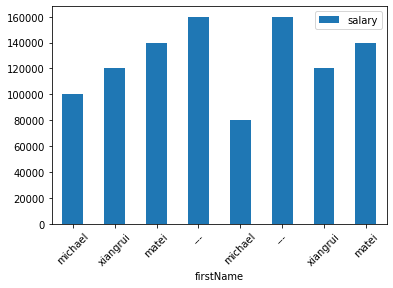

In [248]:
import pandas as pd
import matplotlib.pyplot as plt

plt.clf()
pdDF = nonNullDF.toPandas()
pdDF.plot(x='firstName', y='salary', kind='bar', rot=45)
display()

<Figure size 432x288 with 0 Axes>

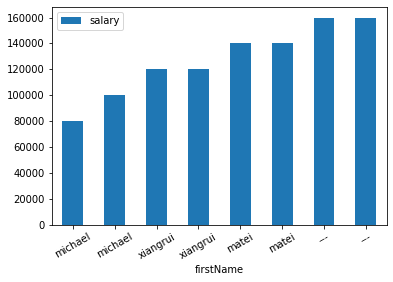

In [255]:
plt.clf()
pdDF2 = df1.toPandas()
pdDF2.plot(x = 'firstName', y = 'salary', kind = 'bar', rot = 30)
display()
